In [1]:
import pandas as pd
import os
import numpy as np

PATH_CSV = r"C:\Users\yangw\iCloudDrive\Desktop\INFO558 Application of deep neutral network\beach_demand_forecast"

df_sales_train = pd.read_csv(os.path.join(PATH_CSV,"sales_train.csv"))
df_items = pd.read_csv(os.path.join(PATH_CSV,"items.csv"))
df_resturant = pd.read_csv(os.path.join(PATH_CSV,"resturants.csv"))
df_sales_test = pd.read_csv(os.path.join(PATH_CSV,"sales_test.csv"))
df_person= pd.read_excel(r"C:\Users\yangw\iCloudDrive\Desktop\INFO558 Application of deep neutral network\beach_demand_forecast\IMGpersonF(1).xlsx")

df_sales_train.date = pd.to_datetime(df_sales_train.date, errors='coerce') 
df_sales_test.date = pd.to_datetime(df_sales_test.date, errors='coerce') 

In [3]:
import plotly.express as px

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [5]:
from scipy import signal

df_plot.item_count = signal.detrend(df_plot.item_count)

fig = px.line(df_plot, x="date", y="item_count", title='RAW Sales by Date')
fig.show()

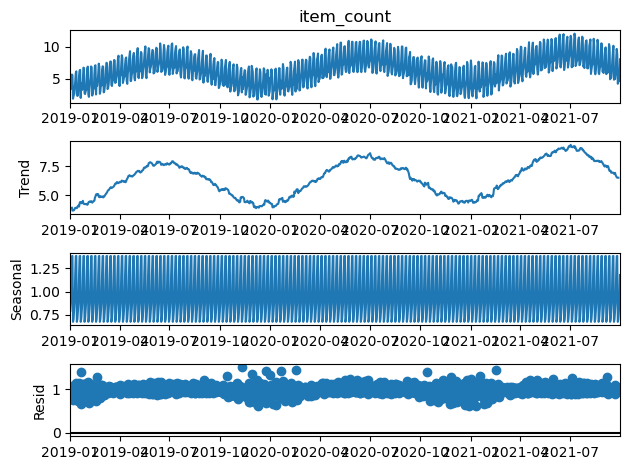

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df_plot = df_sales_train[['date','item_count']].groupby(['date']).mean()

# extrapolate_trend='freq',
adjustment = seasonal_decompose(df_plot.item_count, model='multiplicative') # , model='additive', period=7

# multiplicative
# additive

adjustment.plot()
pyplot.show()

In [10]:
adjustment.trend

date
2019-01-01         NaN
2019-01-02         NaN
2019-01-03         NaN
2019-01-04    3.920000
2019-01-05    3.672857
                ...   
2021-09-26    6.510000
2021-09-27    6.508571
2021-09-28         NaN
2021-09-29         NaN
2021-09-30         NaN
Name: trend, Length: 1004, dtype: float64

In [11]:
adjustment.seasonal

date
2019-01-01    0.793866
2019-01-02    0.889800
2019-01-03    1.177428
2019-01-04    1.378462
2019-01-05    1.380887
                ...   
2021-09-26    0.675276
2021-09-27    0.704281
2021-09-28    0.793866
2021-09-29    0.889800
2021-09-30    1.177428
Name: seasonal, Length: 1004, dtype: float64

In [12]:
df_plot2 = df_plot.copy()

df_plot2.item_count = df_plot2.item_count / adjustment.seasonal / adjustment.trend

fig = px.line(df_plot2.reset_index(), x="date", y="item_count", title='RAW Sales by Date')
fig.show()

In [13]:
df_adjustment = pd.DataFrame(adjustment.seasonal)
df_adjustment['trend'] = adjustment.trend

df_adjustment

,seasonal,trend
date,,
2019-01-01,0.793866,NaN
2019-01-02,0.889800,NaN
2019-01-03,1.177428,NaN
2019-01-04,1.378462,3.920000
2019-01-05,1.380887,3.672857
...,...,...
2021-09-26,0.675276,6.510000
2021-09-27,0.704281,6.508571
2021-09-28,0.793866,NaN


In [13]:
df_items.rename(columns={'id':'item_id',"name":"item_name"}, inplace=True)
df_resturant.rename(columns={"id":"store_id","name":"store_name"}, inplace=True)

df = pd.merge(df_items,df_resturant, on="store_id")
df = pd.merge(df_sales_train,df, on="item_id")
df = pd.merge(df,df_person, on="date")

df.drop(columns=["Unnamed: 0","image","item_name","store_name"], inplace=True)

df['day_of_month']=df.date.dt.day
df['day_of_week']=df.date.dt.dayofweek
df['day_of_week']=df['day_of_week'].apply(lambda x: int(x+1))
df['day_of_year']=df.date.dt.dayofyear
df['week_of_year']=df.date.dt.isocalendar().week
df['month']=df.date.dt.month
df=df[['date','day_of_month','day_of_week','day_of_year','week_of_year','month','item_id','price','cost','store_id','person','item_count']]
df

,date,day_of_month,day_of_week,day_of_year,week_of_year,month,item_id,price,cost,store_id,person,item_count
0,2019-01-01,1,2,1,1,1,3,29.22,29.22,1,17,2
1,2019-01-01,1,2,1,1,1,4,26.42,26.42,1,17,22
2,2019-01-01,1,2,1,1,1,12,4.87,4.87,1,17,7
3,2019-01-01,1,2,1,1,1,13,4.18,4.18,1,17,12
4,2019-01-01,1,2,1,1,1,16,3.21,3.21,1,17,136
...,...,...,...,...,...,...,...,...,...,...,...,...
100395,2021-09-30,30,4,273,39,9,96,21.93,21.93,5,18,0
100396,2021-09-30,30,4,273,39,9,97,28.65,28.65,4,18,0
100397,2021-09-30,30,4,273,39,9,98,5.00,5.00,2,18,0
100398,2021-09-30,30,4,273,39,9,99,5.32,5.32,4,18,0
